In [1]:
import distutils.spawn
from matplotlib import rc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import numpy as np

from models import FCResNet

In [2]:
sns.set(font_scale=1.5)

if distutils.spawn.find_executable('latex'):
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
    rc('text', usetex=True)

In [3]:
default_config= {
    'width': 40,
    'activation': 'ReLU'
}

In [144]:
dim_input = 64
nb_classes = 1

niter = 5
n_init = 10
depth = 1000
grid_beta = list(np.linspace(0, 1.3, 70))
grid_reg = list(np.linspace(0.05, 0.97, 51))
results = []

for reg in grid_reg:
    print(reg)
    for k in range(niter):
        print(k)
        model_config = default_config
        model_config['scaling_beta'] = 0.5
        model_config['depth'] = depth
        model_config['regularity'] = reg

        
        model = FCResNet(dim_input, nb_classes, **model_config)
        
        for beta in grid_beta:
            model.reset_scaling(beta)
            
            for k in range(n_init):
        
                x0 = torch.rand((1, dim_input))
                target = torch.rand((1,))

                h_0 = model.init(x0)
                h_L = model.forward_hidden_state(h_0)
                output = model.final(h_L)

                h_0.retain_grad()
                h_L.retain_grad()

                # model.train()
                loss = torch.norm(output-target) #model.loss(output, target)
                loss.backward()

                h_0_grad = h_0.grad
                h_L_grad = h_L.grad

                results.append({
                    'depth':depth, 
                    'beta': beta, 
                    'regularity': reg,
                    'ratio_hidden_states': float(torch.norm(h_L)/torch.norm(h_0)),
                    'norm_h_0': float(torch.norm(h_0)),
                    'diff_hidden_states': float(torch.norm(h_L - h_0)),
                    'norm_gradient_0': float(torch.norm(h_0_grad)),
                    'norm_gradient_L': float(torch.norm(h_L_grad)),
                    'norm_difference_gradient': float(torch.norm(h_L_grad - h_0_grad)),
                })

0.97
0
1
2
3
4


In [145]:
df = pd.DataFrame(results)

In [121]:
df.to_csv('simulations/relationship-scaling-init.csv')

In [146]:
df.columns = [
    'depth', 'scaling', 'regularity', 'ratio_hidden_states', 'norm_h_0', 'diff_hidden_states', 'norm_gradient_0', 'norm_gradient_L', 
    'norm_difference_gradient']

In [217]:
df['norm_gradient_quotient'] = df['norm_gradient_0'] / df['norm_gradient_L']
df['norm_gradient_scaled_diff'] = df['norm_difference_gradient'] /  df['norm_gradient_L']
df['norm_hidden_states_scaled_diff'] = df['diff_hidden_states'] /  df['norm_h_0']
df['log_norm_hidden_states_scaled_diff'] = np.log10(df['norm_hidden_states_scaled_diff'])
df['log_norm_gradients_scaled_diff'] = np.log10(df['norm_gradient_scaled_diff'])

In [226]:
df2 = df.pivot_table(index='scaling', columns='regularity', values='log_norm_hidden_states_scaled_diff', dropna=False)

In [227]:
df2.index = np.round(df2.index.astype(float), 2)
df2.columns = np.round(df2.columns.astype(float), 2)

In [231]:
df2

regularity,0.05,0.07,0.09,0.11,0.12,0.14,0.16,0.18,0.20,0.22,...,0.80,0.82,0.84,0.86,0.88,0.89,0.91,0.93,0.95,0.97
scaling,,,,,,,,,,,,,,,,,,,,,
0.00,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.000000,16.00000,16.000000,16.000000,16.00000,16.000000,16.00000,16.000000,16.000000,16.000000
0.02,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.000000,16.00000,16.000000,16.000000,16.00000,16.000000,16.00000,16.000000,16.000000,16.000000
0.04,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.000000,16.00000,16.000000,16.000000,16.00000,16.000000,16.00000,16.000000,16.000000,16.000000
0.06,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.000000,16.00000,16.000000,16.000000,16.00000,16.000000,16.00000,16.000000,16.000000,16.000000
0.08,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,...,16.000000,16.00000,16.000000,16.000000,16.00000,16.000000,16.00000,16.000000,16.000000,16.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.40,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-1.638877,-1.59152,-1.529374,-1.434899,-1.41629,-1.311184,-1.24091,-1.118219,-1.037111,-0.973748
1.42,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-1.638877,-1.59152,-1.529374,-1.434899,-1.41629,-1.311184,-1.24091,-1.118219,-1.037111,-0.973748
1.44,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-1.638877,-1.59152,-1.529374,-1.434899,-1.41629,-1.311184,-1.24091,-1.118219,-1.037111,-0.973748


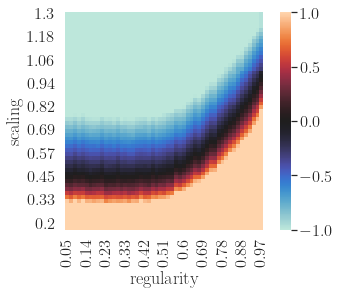

In [232]:
sns.heatmap(df2.iloc[-10:8:-1], vmin=-1, vmax=1, center=0, xticklabels=5, yticklabels=6, square=True)#, cmap='Spectral'
plt.savefig('figures/heatmap-scaling-regularity.pdf', bbox_inches='tight')
plt.show()

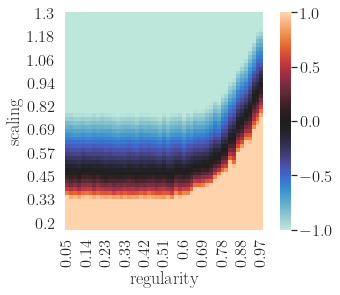

In [225]:
sns.heatmap(df2.iloc[-10:8:-1], vmin=-1, vmax=1, center=0, xticklabels=5, yticklabels=6, square=True)#, cmap='Spectral'
plt.savefig('figures/heatmap-scaling-regularity-gradients.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# To change NANs into the right values.

In [ ]:
df2.iloc[:25] = df2.iloc[:25].fillna(16)
df2.iloc[-15:] = df2.iloc[-15:].fillna(-2)

In [229]:
for k in np.arange(1.26, 1.5, 0.02):
    df2.loc[k] = df2.loc[1.24]

In [230]:
df2.index = np.round(df2.index.astype(float), 2)